In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import missingno as msno

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
seed_value = 99
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

sns.set_theme(style="darkgrid", context= "paper")

In [2]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

In [3]:
HMDA_clean_final['loan_granted'] = (HMDA_clean_final['loan_granted'] == 'Granted').astype(int)

HMDA_encoded = pd.get_dummies(HMDA_clean_final, columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=True)

X = HMDA_encoded.drop(columns=['loan_granted'])
y = HMDA_encoded['loan_granted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(545238, 19) (136310, 19) (170388, 19)
(545238,) (136310,) (170388,)


XXX

In [5]:
BLD_train_df = pd.get_dummies(HMDA_clean_final.loc[X_train.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)

In [6]:
for col in BLD_train_df.columns:
    if BLD_train_df[col].dtype == 'bool':
        BLD_train_df[col] = BLD_train_df[col].astype(int)

In [7]:
BLD_train_df.head()

,county_code,interest_rate,loan_to_value_ratio,loan_granted,applicant_sex_Male,applicant_sex_Female,applicant_race-1_Black or African American,applicant_race-1_White,loan_type_Conventional,loan_type_FHA,...,debt_to_income_ratio_36,debt_to_income_ratio_37%-41%,debt_to_income_ratio_41%-45%,debt_to_income_ratio_46%-49%,debt_to_income_ratio_50%-60%,debt_to_income_ratio_<20%,debt_to_income_ratio_>60%,debt_to_income_ratio_missing,lien_status_First lien,lien_status_Subordinate lien
115410,30013,4.990000,100.000000,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
630420,48119,4.560661,71.241202,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
612581,48085,4.560661,71.241202,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1
670964,48085,4.560661,71.241202,1,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
179727,30111,7.000000,52.055000,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[inFairness]'


In [9]:
privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

privileged_groups_2 = [{'applicant_sex_Male': 1}]
unprivileged_groups_2 = [{'applicant_sex_Male': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
train_bld_2 = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_sex_Male', 'applicant_sex_Female'], favorable_label=1.0, unfavorable_label=0.0)


metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train_2 = BinaryLabelDatasetMetric(train_bld_2, 
                                             unprivileged_groups=unprivileged_groups_2,
                                             privileged_groups=privileged_groups_2)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_train.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Sex = %f" % metric_orig_train_2.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.148808
Difference in mean outcomes between unprivileged and privileged groups - Sex = -0.036731


In [10]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(train_bld)

In [11]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_transf_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.000000


In [12]:
print(pd.DataFrame(train_bld.convert_to_dataframe()[0][["county_code", "interest_rate", "loan_to_value_ratio"]]).head(), "\n", "\n", X_train[["county_code", "interest_rate", "loan_to_value_ratio"]].head())

        county_code  interest_rate  loan_to_value_ratio
115410      30013.0       4.990000           100.000000
630420      48119.0       4.560661            71.241202
612581      48085.0       4.560661            71.241202
670964      48085.0       4.560661            71.241202
179727      30111.0       7.000000            52.055000 
 
        county_code  interest_rate  loan_to_value_ratio
115410       30013       4.990000           100.000000
630420       48119       4.560661            71.241202
612581       48085       4.560661            71.241202
670964       48085       4.560661            71.241202
179727       30111       7.000000            52.055000


In [13]:
X_train_fair = pd.DataFrame(train_bld.convert_to_dataframe()[0])

In [14]:
X_train_fair.columns.difference(X_train.columns)

Index(['applicant_race-1_Black or African American', 'applicant_sex_Male',
       'debt_to_income_ratio_0', 'lien_status_First lien', 'loan_granted',
       'loan_type_Conventional'],
      dtype='object')

In [15]:
X_train_fair = X_train_fair.drop(columns=['applicant_race-1_Black or African American', 'applicant_sex_Male',
       'debt_to_income_ratio_0', 'lien_status_First lien', 'loan_granted',
       'loan_type_Conventional'])

In [16]:
print(X_train_fair.shape, X_train.shape, X_train_scaled.shape)

(545238, 19) (545238, 19) (545238, 19)


In [37]:
X_train_fair.head()

,county_code,interest_rate,loan_to_value_ratio,applicant_sex_Female,applicant_race-1_White,loan_type_FHA,loan_type_VA,loan_type_FSA/RHS,debt_to_income_ratio_20%-<30%,debt_to_income_ratio_30%-<36%,debt_to_income_ratio_36,debt_to_income_ratio_37%-41%,debt_to_income_ratio_41%-45%,debt_to_income_ratio_46%-49%,debt_to_income_ratio_50%-60%,debt_to_income_ratio_<20%,debt_to_income_ratio_>60%,debt_to_income_ratio_missing,lien_status_Subordinate lien
115410,30013.0,4.990000,100.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
630420,48119.0,4.560661,71.241202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
612581,48085.0,4.560661,71.241202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
670964,48085.0,4.560661,71.241202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
179727,30111.0,7.000000,52.055000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
# recreate fair training set from x_train_fair (which contains x and y probably - check splits above)

array([[-1.44813610e+00,  3.55598300e-01,  1.55154613e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.43057973e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.39506631e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00,  2.46483423e+00],
       ...,
       [ 5.41033231e-01, -1.39650438e+00, -1.05098414e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.66037244e-01, -8.78743543e-01, -4.76921098e-01, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01],
       [-2.28186586e+00, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01]])

In [17]:
'''
directory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'

os.makedirs(directory, exist_ok=True)

pickle_file = os.path.join(directory, 'subsets_data.pickle')

subsets = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_val_scaled': X_val_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

with open(pickle_file, 'wb') as f:
    pickle.dump(subsets, f)
'''

"\ndirectory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'\n\nos.makedirs(directory, exist_ok=True)\n\npickle_file = os.path.join(directory, 'subsets_data.pickle')\n\nsubsets = {\n    'X_train_scaled': X_train_scaled,\n    'X_test_scaled': X_test_scaled,\n    'X_val_scaled': X_val_scaled,\n    'y_train': y_train,\n    'y_test': y_test,\n    'y_val': y_val\n}\n\nwith open(pickle_file, 'wb') as f:\n    pickle.dump(subsets, f)\n"

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
17039/17039 [==============================] - 42s 2ms/step - loss: 0.3502 - accuracy: 0.8733 - val_loss: 0.3125 - val_accuracy: 0.8907
Epoch 2/10
17039/17039 [==============================] - 94s 5ms/step - loss: 0.3182 - accuracy: 0.8876 - val_loss: 0.3113 - val_accuracy: 0.8885
Epoch 3/10
17039/17039 [==============================] - 36s 2ms/step - loss: 0.3127 - accuracy: 0.8906 - val_loss: 0.3046 - val_accuracy: 0.8940
Epoch 4/10
17039/17039 [==============================] - 33s 2ms/step - loss: 0.3094 - accuracy: 0.8920 - val_loss: 0.2995 - val_accuracy: 0.8964
Epoch 5/10
17039/17039 [==============================] - 31s 2ms/step - loss: 0.3071 - accuracy: 0.8927 - val_loss: 0.3014 - val_accuracy: 0.8948
Epoch 6/10
17039/17039 [==============================] - 87s 5ms/step - loss: 0.3057 - accuracy: 0.8937 - val_loss: 0.2960 - val_accuracy: 0.8972
Epoch 7/10
17039/17039 [==============================] - 61s 4ms/step - loss: 0.3042 - accuracy: 0.8944 - val_loss: 0

5325/5325 - 5s - loss: 0.2943 - accuracy: 0.8973 - 5s/epoch - 933us/step

Test accuracy: 0.8973343372344971


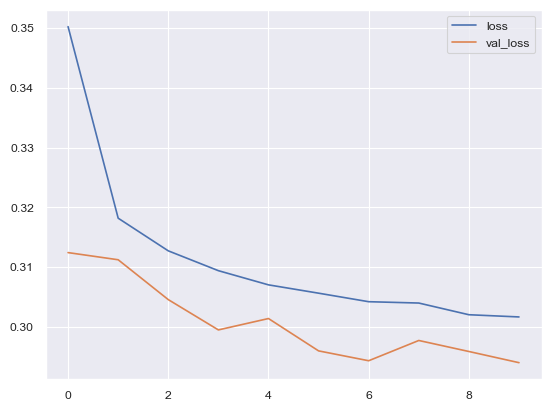

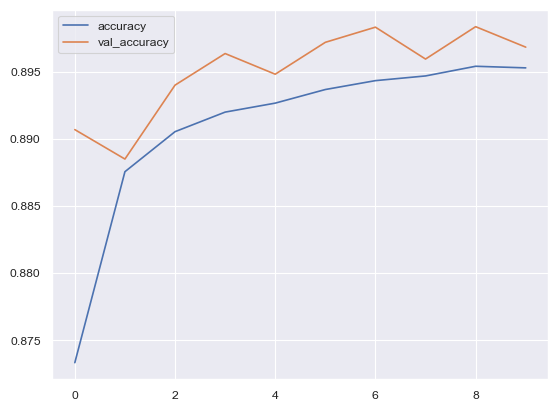

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5325/5325 [==============================] - 6s 1ms/step
[[58018 13630]
 [ 3863 94877]]
Accuracy: 0.8973343193182618
Precision: 0.8743859843143761
Recall: 0.9608770508405915
F1 Score: 0.9155934705930605
AUC: 0.9394994674496466


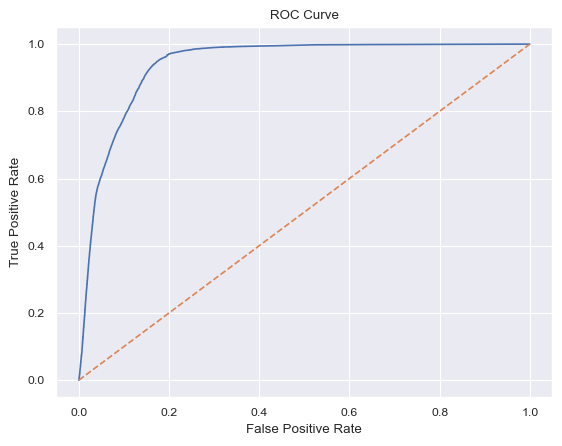

In [20]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [21]:
results = pd.DataFrame({'label': y_test})
results["score"] = y_pred.astype(int)
results["applicant_sex"] = HMDA_clean_final.loc[results.index, "applicant_sex"]
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results["applicant_sex"] = results["applicant_sex"].astype("object")
results["applicant_race-1"] = results["applicant_race-1"].astype("object")

In [22]:
print(results.head(), "\n", results.shape, "\n", results.dtypes)

        label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      1        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1    object
dtype: object


In [23]:
import aequitas

audit = aequitas.Audit(results)

In [24]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)

In [25]:
absolute_metrics = g.list_absolute_metrics(xtab)

xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,108507,applicant_sex,Female,36503,22653,4855,1321,21332,31648,32969,26187,59156,170388
1,0,binary 0/1,108507,applicant_sex,Male,72004,39228,8775,2542,36686,63229,65771,45461,111232,170388
2,0,binary 0/1,108507,applicant_race-1,Black or African American,13629,12824,2408,775,12049,11221,11996,14457,26453,170388
3,0,binary 0/1,108507,applicant_race-1,White,94878,49057,11222,3088,45969,83656,86744,57191,143935,170388


In [26]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,applicant_sex,Female,0.90,0.96,0.81,0.06,0.13,0.19,0.04,0.94,0.87,0.34,0.62,0.56
1,applicant_sex,Male,0.90,0.96,0.81,0.06,0.12,0.19,0.04,0.94,0.88,0.66,0.65,0.59
2,applicant_race-1,Black or African American,0.88,0.94,0.83,0.06,0.18,0.17,0.06,0.94,0.82,0.13,0.52,0.45
3,applicant_race-1,White,0.90,0.96,0.80,0.06,0.12,0.20,0.04,0.94,0.88,0.87,0.66,0.60


In [27]:
aqp = aequitas.plotting.Plot()

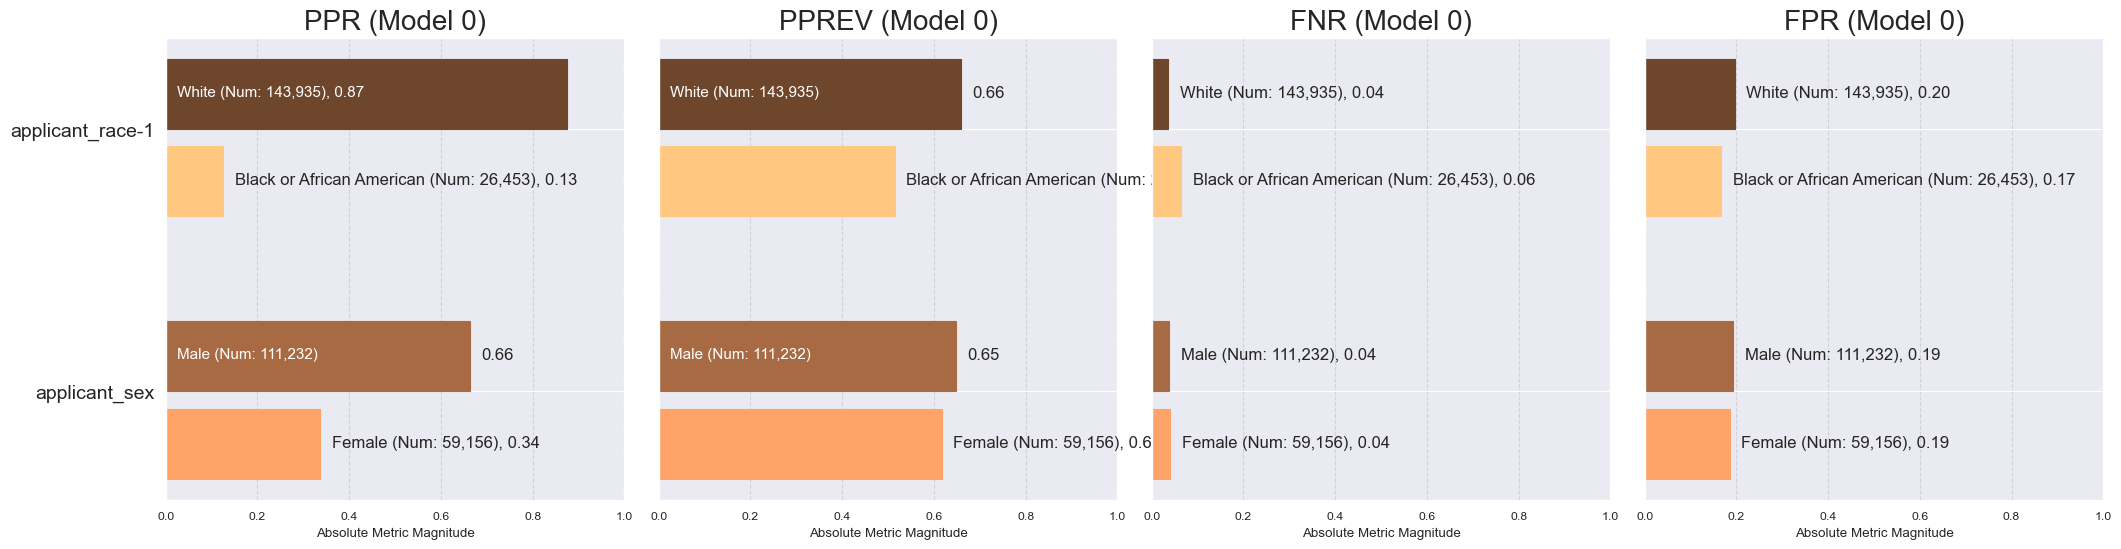

<Figure size 640x480 with 0 Axes>

In [35]:
group_metric_all = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

In [29]:
b = aequitas.bias.Bias()

In [30]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,108507,applicant_sex,Female,0.895598,0.959932,0.814603,0.058315,0.133003,0.185397,0.040068,0.941685,0.866997,36503,22653,0.336411,0.617063,4855,1321,21332,31648,32969,26187,59156,170388,0.557323,0.506958,0.953241,0.987320,1.091365,0.899907,0.960496,1.036707,0.998524,1.009449,1.006936,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
1,0,binary 0/1,108507,applicant_sex,Male,0.898258,0.961351,0.806977,0.064801,0.121868,0.193023,0.038649,0.935199,0.878132,72004,39228,0.663589,0.647332,8775,2542,36686,63229,65771,45461,111232,170388,0.591296,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
2,0,binary 0/1,108507,applicant_race-1,Black or African American,0.879673,0.935395,0.833437,0.060434,0.176682,0.166563,0.064605,0.939566,0.823318,13629,12824,0.125605,0.515216,2408,775,12049,11221,11996,14457,26453,170388,0.453484,0.143648,0.781610,0.933762,1.493784,0.960068,0.848859,1.814794,0.969923,1.036897,1.002682,White,White,White,White,White,White,White,White,White,White
3,0,binary 0/1,108507,applicant_race-1,White,0.900580,0.964401,0.803780,0.062947,0.118278,0.196220,0.035599,0.937053,0.881722,94878,49057,0.874395,0.659173,11222,3088,45969,83656,86744,57191,143935,170388,0.602661,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,White,White,White,White,White,White,White,White,White,White


In [31]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [32]:
disparity_significance

[]